# Solar System planets image classification
### Inteligencia Artirficial para los Sistemas de Control Autónomos
### Máster de Ciencia y Tecnología desde el Espacio


## Objectives

- Introduce some basic Machine Learning concepts.
- Work with a basic Machine Learning workflow.
- Illustrate an application of classical Machine Learning to image classification.
- Understand the importance of hyperparameter settings.

## Introduction


Remember that the workflow usually implemented in ML projects is as follows.

1. Data adquisition
2. Exploratory analysis
3. Data preprocessing
4. Model training
5. Model validation

In this assignment we will train several classifiers to distinguish the different planets in the Solar System in base of its photograph. TODO.

This assignment uses a dataset created by Emirhan Bulut.

## Preliminary steps

The dataset has been taken from Kaggle, a pretty popular website among the Machine Learning community. Take some time to explore the [dataset](https://www.kaggle.com/robervalt/sunspots), but you will not need to download it because this notebook automatically downloads the dataset from [Internet](https://gist.githubusercontent.com/dfbarrero/466ad8dc4fc904bb2de1d69ef61319f1/raw/7feea731c24e2a8149731f27c6d66518e542a836/Sunspots.csv).

## Import libraries


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

## Define some utility functions

Your do not need to understand this, thay are just utility functions to maintain a nicer code.

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

def plot_predict(observed, predicted):
  plt.figure(figsize=(20, 10))
  plt.plot(observed)
  plt.plot(predicted, linestyle="dashed")
  #plt.title('Observation vr. prediction')
  plt.ylabel('Sunspots')
  plt.xlabel('Index')
  plt.legend(['Observed', 'Predicted'], loc='upper right')
  plt.show()

def plot_histograms(observed, predicted):
    """
    Plot two side-by-side histograms with the observed and predicted sunspots
    """
    #plt.figure(figsize=(40, 5))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.histplot(predicted, ax=ax2);
    ax2.title.set_text("Predictions")
    sns.histplot(observed, ax=ax1);
    ax1.title.set_text("Observations")

def plot_train_test(train, test):
    plt.figure(figsize=(20, 6));
    sns.lineplot(data = train, color="blue")

    x = range(len(train), len(train) + len(test))
    sns.lineplot(x=x, y=test, color="red", linestyle="dotted")
    plt.ylabel("Observed sunspots");

def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

def split_timeseries(dataset, ratio=0.8):
    '''
      dataset[:, 0] must contain the target
    '''
    split_time = int(ratio * len(dataset))

    train = dataset[:split_time]
    test = dataset[split_time:]

    print("Number of instances: " + str(len(dataset)))
    print("Number of instances for train: " + str(split_time))
    print("Number of instances for validation: " + str(len(dataset) - split_time))

    plt.figure(figsize=(20, 6));
    plt.plot(train['Sunspots']);
    plt.plot(test['Sunspots'], linestyle="dotted");
    plt.xlabel("Year");
    plt.ylabel("Observed sunspots");
    plt.legend(['Train', 'Test'], loc='upper right')

    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

    return X_train, y_train, X_test, y_test

## Load dataset

Given that the dataset is a collection of images, first we need to download them in order to build our feature matrix. To that end we use a nice feature of notebook that allows to execute a system command. You do not need to know how the following command works, all you need is to know that it is going to download a zip file from Internet with the images.

In [23]:
!wget https://github.com/emirhanai/Planets-and-Moons-Dataset-AI-in-Space/raw/main/Planets_Moons_Data.zip

/bin/bash: /home/david/anaconda3/envs/ml37/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2022-12-21 11:49:15--  https://github.com/emirhanai/Planets-and-Moons-Dataset-AI-in-Space/raw/main/Planets_Moons_Data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/emirhanai/Planets-and-Moons-Dataset-AI-in-Space/main/Planets_Moons_Data.zip [following]
--2022-12-21 11:49:15--  https://raw.githubusercontent.com/emirhanai/Planets-and-Moons-Dataset-AI-in-Space/main/Planets_Moons_Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21015623 (20M) [application/zip]
Saving 

In [24]:
!unzip Planets_Moons_Data.zip

/bin/bash: /home/david/anaconda3/envs/ml37/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  Planets_Moons_Data.zip
replace Planets and Moons/Earth/Earth (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Let's checkout if the dataset has been correctly downloaded.

In [26]:
!ls -l

/bin/bash: /home/david/anaconda3/envs/ml37/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 55080
drwxrwxr-x 13 david david     4096 may  8  2022 'Planets and Moons'
-rw-rw-r--  1 david david 11984276 dic 21 11:44  planets.csv
-rw-rw-r--  1 david david  2375718 dic 21 11:48  planets.ipynb
-rw-rw-r--  1 david david 21015623 dic 21 11:20  Planets_Moons_Data.zip
-rw-rw-r--  1 david david 21015623 dic 21 11:49  Planets_Moons_Data.zip.1


It would be better to visualize one of the images.

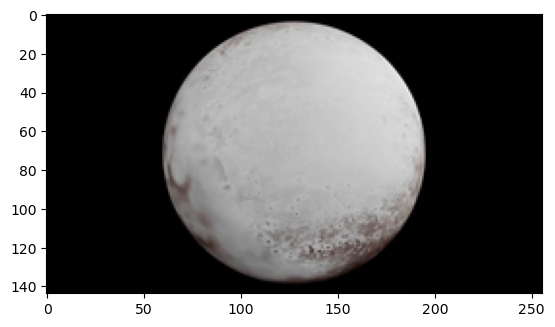

In [27]:
%matplotlib inline

import os
import pandas as pd
import time
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

from PIL import ImageOps

DATAPATH = "Planets and Moons"

img = Image.open(os.path.join(DATAPATH, "Pluto/Pluto (100).jpg"))
img.load()
plt.imshow(img)

In [28]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

We can transform the image to a plain numpy array simply as.

In [29]:
np.asarray(img, dtype="uint8").shape

(144, 256, 3)

## Build the dataset

Given the collection of images, we need to extract the features to build the dataset. That is done in the following code, that you do not need to understand.

In [30]:
DATAPATH = "Planets and Moons"




columnNames = list()
columnNames.append('label')
size = 28 * 28 * 3

for i in range(size):
    pixel = str(i)
    columnNames.append('pixel' + pixel)

# Create a Pandas dataframe for storing data
df = pd.DataFrame(columns = columnNames)

for dirs in tqdm(os.listdir(DATAPATH)):
    print("Iterating: " + dirs + " folder")

    for file in tqdm(os.listdir(os.path.join(DATAPATH, dirs))):
        #print("Doing " + file)
        img = Image.open(os.path.join(DATAPATH, dirs, file))
        img.load()

        border = (58, 2, 58, 2) # left, top, right, bottom
        img = ImageOps.crop(img, border)
        img = img.resize((28, 28))

        # create a numpy array for image pixels
        imgdata = np.asarray(img, dtype="uint8")
        #print(imgdata.shape)
        imgdata = imgdata.reshape(1, -1)
        row = pd.DataFrame(imgdata)
        row.columns = columnNames[1:] # First entry is 'label', avoid it
        row['label'] = dirs
        
        df = df.append(row)

  0%|          | 0/11 [00:00<?, ?it/s]

Iterating: MakeMake folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Jupiter folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Mars folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Mercury folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Moon folder


  0%|          | 0/148 [00:00<?, ?it/s]

Iterating: Uranus folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Neptune folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Pluto folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Earth folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Venus folder


  0%|          | 0/149 [00:00<?, ?it/s]

Iterating: Saturn folder


  0%|          | 0/149 [00:00<?, ?it/s]

Dataset contains a dataframe with the images in a Machine Learning friendly format. The process of building the dataset may be time-consuming in case of large amount of data. For this reasing it is quite common to store it in disk.

In [31]:
df.to_csv("planets.csv", index=False)

This file has been created in the virtual machine, so you do not have direct access to it, but you can still download it with the following function.

In [32]:
from IPython.display import FileLink

display(FileLink("planets.csv"))

/home/david/repositorios/docencia/dataCourse/assignments/planets/planets.csv

## Exploratory analysis

Always observe your data before doing any futher processing. As usual, we try to identify NaN values, number of instances, attributes and classes, outlayers, correlations and in general any information about our data that helps us to better understand it and hence train better models.

In [65]:
## YOUR EDA HERE

MakeMake    149
Jupiter     149
Mars        149
Mercury     149
Uranus      149
Neptune     149
Pluto       149
Earth       149
Venus       149
Saturn      149
Moon        148
Name: label, dtype: int64

## Preprocess data

Our data has values between 0 and 255, which is not optimal for some of the algorithms we will try, so we normalize them. In this case the variance of our attributes is quite similar, if not identical, so normalization will not make a big difference, however, we will do it, but first, we will build the feature matrix and target vector as Scikit-Learn requires.

In [63]:
x = df.drop("label", axis=1)
y = df["label"]

display(x.head())
display(y.head())

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    MakeMake
0    MakeMake
0    MakeMake
0    MakeMake
0    MakeMake
Name: label, dtype: object

Now we standarize our data.

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x)
X = scaler.transform(x)

X

array([[-0.31633394, -0.31633394, -0.31633394, ..., -0.31633394,
        -0.31633394, -0.31633394],
       [-0.31633394, -0.31633394, -0.31633394, ..., -0.31633394,
        -0.31633394, -0.31633394],
       [-0.31633394, -0.31633394, -0.31633394, ..., -0.31633394,
        -0.31633394, -0.31633394],
       ...,
       [ 3.16121632,  3.16121632,  3.16121632, ...,  3.16121632,
         3.16121632,  3.16121632],
       [ 3.16121632,  3.16121632,  3.16121632, ...,  3.16121632,
         3.16121632,  3.16121632],
       [ 3.16121632,  3.16121632,  3.16121632, ...,  3.16121632,
         3.16121632,  3.16121632]])

Now we can split into train and test datasets.

In [57]:
from sklearn.model_selection import train_test_split 
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(f"X shape: {X.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_train shape: {X_test.shape}")

X shape: (1638, 2352)
X_train shape: (1146, 2352)
X_train shape: (492, 2352)


## Predictive modelling

### Set up a baseline

In order to assess correctly our model metrics, we first need something to compare with. Absolute metrics have little meaning without a context. To this end it is quite common to apply a dumb forecasting just to have an estimation of the magnitude of the metrics. In our case we will always predict the most frequent class.

In [81]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
y_model = dummy_clf.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_model)

0.09349593495934959

In [87]:
y_model[:10]

array(['Earth', 'Earth', 'Earth', 'Earth', 'Earth', 'Earth', 'Earth',
       'Earth', 'Earth', 'Earth'], dtype='<U5')

Now we are going to train several types of classifiers trying to improve our baseline accuracy. We will use accuracy as metric, given that it is a classification task and the classes are balanced.

#### K-nn classifier

Model fit:

In [99]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)                  
y_model = model.predict(X_test)             

Model evaluation:

In [100]:
from sklearn.metrics import accuracy_score

results = {}

results['knn'] = accuracy_score(y_test, y_model)
results['knn']

0.9939024390243902

#### Support Vector Machine (SVM) classifier

In [101]:
from sklearn.svm import SVC

model = SVC()

model.fit(X_train, y_train)                   
y_model = model.predict(X_test)              

In [102]:
results['svm'] = accuracy_score(y_test, y_model)
results['svm']

0.9451219512195121

#### Classification tree

In [103]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)          
y_model = model.predict(X_test)              

In [104]:
results['tree'] = accuracy_score(y_test, y_model)

Finally, we compare the accuracy of our models:

In [105]:
results

{'knn': 0.9939024390243902,
 'svm': 0.9451219512195121,
 'tree': 0.9817073170731707}

# Exercises

### Initial steps

1. Understand the workflow implemented in this notebook. You do not need to understand the details of the code but of course it is better if you can understand that. 

2. Complete this notebook filling in the EDA section.

### Cross-validation

3. The validation done above, depending on the size of the dataset and its properties, may not be very reliable. Evaluate the three previous classifiers with 10-folders cross validation and fill the following table. 
    * Please, observe that when using CV you do not need to split train and test, so you should use the whole dataset.
    * Think about to what extend you are free to select any number of folds in cross validation.

| Model | Accuracy | Accuracy (10-CV) |
| ---   | --- | --- | 
| Baseline   |     |    | 
| KNN   | | |
| SVM   | | |
| Tree  | | |

KNN

In [124]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()
scores = cross_val_score(model, X, y, cv=5)
print(scores.std())
scores = cross_val_score(model, X, y, cv=10)
print(scores.std())

0.005667578175761211
0.009125000692388655


SVM

Tree

4. Now compare the standard deviation of the accuracy estimated with cross validation for different number of folds (5 and 10). Fill out the following table and try to identify any pattern.

| Model | $\sigma$ (cv=10) | $\sigma$ (cv=5) |
| ---   | --- | --- |
| KNN   |     |     |
| SVM   | | | 
| Tree  | | |

KNN

SVM

Tree

### Alternative evaluation methods

5. Display the confusion matrix for the tree models trained with the train dataset. Do they fail/success in the same way?

KNN

SVM

Tree

6. Scikit-Learn comes with a handy function named classification_report, that provides a range of evaluation metrics for classifiers. Search information about this function and provide a report the SVM classifier.

### Hyper parameter optimization

7. Train a KNN model for different values of *n_neighbors* and plot its accuracy.

8.Train a SVM classifier for different values of *C* and plot its accuracy. Search in Internet which values of C are reasonable.

9. Train a classification tree for diferent values of *max_depth*. This hyperparameters determines the maximun depth that is allowed to the learned tree.

### Predictions on new data

We train models because we want to use them with data that does not belong to our dataset. The following code trains a model, evaluate its performance and finally applies it to a new image taken from Internet.

In [136]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)

print(f"5-CV accuracy estimation: {cross_val_score(model, X, y, cv=5).mean()}")

5-CV accuracy estimation: 0.997555381517118


This model is going into production, so we train with the whole dataset for best performance.

In [137]:
model.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

That's nice, we finally have our model ready for fun. Now it is time to download an image and preprocess it to make our model happy.